# 1. Import and Install Dependencies

In [1]:
import cv2
import numpy as np
import os
import mediapipe as mp
import uuid

from matplotlib import pyplot as plt

# 2. Keypoints using MP Hands

importiamo il modello Holistic di MediaPipe

In [2]:
mp_hands = mp.solutions.hands # Hands model
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

funzione di riconoscimento: convertiamo prima l'immagine dal canale BGR (output di OpenCV feed) a quello RGB, necessario per MediaPipe;
alla fine riconvertiamo in BGR

In [3]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction with the Holistic model
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

formattiamo, personalizziamo i landmark in maniera grafica

In [4]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(20,22,80), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(50,44,71), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(150,22,66), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(50,255,10), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(150,22,66), thickness=2, circle_radius=2), 
                             mp_drawing.DrawingSpec(color=(50,66,230), thickness=2, circle_radius=2)
                             ) 

cicliamo su tutti i frame del video

con HOLISTIC

In [141]:
cap = cv2.VideoCapture(0) #accediamo alla nostra webcam
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened(): #finchè webcam attiva...

        # Read feed
        ret, frame = cap.read() #prendiamo il singolo frame      

        # Make detections
        image, results = mediapipe_detection(frame, holistic)       

        # Draw landmarks to the screen in real time 
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'): #se premiamo q -> quit
            break

    cap.release()
    cv2.destroyAllWindows()

con HANDS

In [6]:
cap = cv2.VideoCapture(0) #accediamo alla nostra webcam
# Set mediapipe model 
with mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as hands:
    while cap.isOpened(): #finchè webcam attiva...

        # Read feed
        ret, frame = cap.read() #prendiamo il singolo frame

        # Make detections
        image, results = mediapipe_detection(frame, hands)
        print(results)
        
        if results.multi_hand_landmarks:
        
            # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
            for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

                mp_drawing.draw_landmarks(     
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(255,70,0), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(70,255,0), thickness=2, circle_radius=2)
                    )

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'): #se premiamo q -> quit
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.solution_base.SolutionOutputs'>
<class 'mediapipe.python.soluti

disegniamo/visualizziamo i landmark sul frame estratto

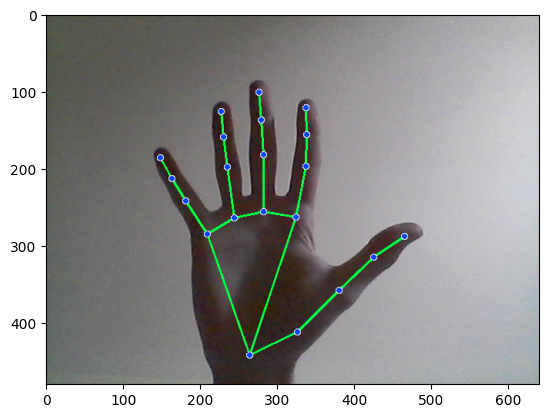

In [7]:
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

tutte le nostre immagini sono **480**x**640** pixel.

In [8]:
cv2.imwrite(r"C:\Users\follo\OneDrive\Desktop\test.png", image)

True

# 3. Extract Keypoint Values

restituisce il numero dei landmark usati per la parte del corpo specificata

Lavoriamo su ciascun landkmark: 

- creiamo degli array dove memorizzare le sue coordinate (dei landmark)

- Useremo degli array di zero quando una certa parte del corpo non è riconosciuta/presente, per non fare andare in errore il sistema.

In [5]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    #face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    #pose = remove_pose_kp(pose)
    return np.concatenate([pose, lh, rh])

In [5]:
def extract_keypoints_hands(results, hand_landmarks):
    h = np.array([[res.x, res.y, res.z] for res in hand_landmarks.landmark]).flatten() if results.multi_hand_landmarks else np.zeros(21*3)    
    return h

**N.B.** usiamo *flatten()* perchè vogliamo un solo array, unidimensionale, perchè ci servirà questo formato per la LSTM; infatti, senza flatten() avremo una matrice, un array bidimensionale (ciascun landmark avrà *x* valori associati)

come abbiamo detto prima, creiamo un array vuoto (di zeri), per gestire l'errore nel caso in cui una parte del corpo non è riconosciuta.

nello specifico:

res.x, res.y, res.z sono i singoli valori delle coord. per ciascun landmark, che verranno inseriti in un array più grande, ciclando per ogni landmark:

- se non esistono coordinate per i landmark, quindi quella parte del corpo non è riconosciuta, viene creato un array vuoto

Per quello detto prima, la dimensione totale dell'array della posa sarà **132** (33 x 4) mentre l'array di ciascuna delle mani avrà dimensione **63** (21 x 3). Quindi:
- avremo per ogni frame **75** landmarks tridimensionali (quadridimensionali solo per la posa, che include l'attributo *visibilità*)

abbiamo estratto i **keypoints** per il frame di interesse, che saranno utili per il riconoscimento dei gesti/segni

# 4. Setup Folders for Collection

avremo la seguente struttura: 5 azioni -> 30 video per azione -> 30 frame per ciascuna azione -> ogni frame contiene un array di dati, in particolare **75** keypoints per frame. In generale:

- AZIONI
    - VIDEO
        - FRAME


cioè:


- *azione_1*
    - *1*
    - *...*
    - *29*
        - *array_1*
        - *...*
        - *array_29*
    

- *azione_2*
    - *1*
    - *...*
    - *29*
        - *array_1*
        - *...*
        - *array_29*

- *...*

In [6]:
# accediamo ai keypoints estratti sopra
IMG_PATH = os.path.join(r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\images") # path per il dataset di immagini
DATA_PATH = os.path.join(r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\MP_Data") # Path for exported data, numpy arrays

# Actions that we try to detect
actions = np.array(["preghiera", "saluto", "baci", "applauso"])

# Sixty videos worth of data
no_sequences = 60

# Videos are going to be 30 frames in length
sequence_length = 30 #usiamo 30 frame, ciascuno con 75 keypoints da valutare

elimino kp

In [ ]:
for action in actions:
        # Loop through sequences aka videos
        for sequence in range(0, 30):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):
                path = os.path.join(DATA_PATH, action, str(sequence))
                print(path)
                for kp in os.listdir(path):
                    print(kp)
                    npy_path = os.path.join(path, kp)
                    os.remove(npy_path)

In [55]:
for action in actions: 
    for sequence in range(no_sequences): #da 0 a 59
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))
        except:
            pass #se esistono già, skippa la creazione

In [56]:
for action in actions: 
    for sequence in range(no_sequences): #da 0 a 59
        try: 
            os.makedirs(os.path.join(IMG_PATH, action, str(sequence)))
        except:
            pass #se esistono già, skippa la creazione

# 5. Collect Keypoint Values for Training and Testing

#### **Costruzione del dataset**

- ##### leggiamo i frame che vengono estratti mentre la fotocamera è accesa: a partire da essi estrarremo i keypoints
    - come nella sezione 2., ma ora cicliamo per ogni azione, poi per ogni video, poi per ogni frame
        - stamperemo a schermo del testo e metteremo in pausa per 2 secondi, per capire quale gesto performare e quando

Poichè abbiamo a disposizione un gesto di nostro interesse nel dataset Jester, lo integriamo nel nostro. Prima però costruiamo il nostro dataset :

#### con HOLISTIC

In [9]:
cap = cv2.VideoCapture(0)

# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(0, 30):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                # Make detections
                image, results = mediapipe_detection(frame, holistic)
                #print(results)

                # Draw landmarks
                draw_styled_landmarks(image, results)
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2000)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,12), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # NEW Export keypoints
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

#### con HANDS

In [58]:
cap = cv2.VideoCapture(0) # uso la videocamera del pc

# Set mediapipe model 
with mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5) as hands:  
    
    # NEW LOOP
    # Loop through actions
    for action in actions:
        # Loop through sequences aka videos
        for sequence in range(0, 30):#range(no_sequences):
            # Loop through video length aka sequence length
            for frame_num in range(sequence_length):

                # Read feed
                ret, frame = cap.read()

                #salvo frame acquisiti
                img_name = os.path.join(IMG_PATH, action, str(sequence), action+"."+"{}.jpg".format(str(uuid.uuid1())))
                print(img_name)
                cv2.imwrite(img_name, frame)

                # Make detections       
                image, results = mediapipe_detection(frame, hands)  
                
                first_hand_keypoints = np.zeros(21*3)
                second_hand_keypoints = np.zeros(21*3)

                #TODO aggiustare perchè if lo fa già extract_keypoints
                if results.multi_hand_landmarks:
                    
                    # num è il numero delle mani che riconosce!! 0 la prima, 1 eventualmente la seconda
                    for num, hand_landmarks in enumerate(results.multi_hand_landmarks):   

                        mp_drawing.draw_landmarks(     
                            image,
                            hand_landmarks,
                            mp_hands.HAND_CONNECTIONS,
                            mp_drawing.DrawingSpec(color=(245,70,0), thickness=2, circle_radius=2),
                            mp_drawing.DrawingSpec(color=(70,255,0), thickness=2, circle_radius=2)
                        )           

                        if num == 0: # prima mano riconosciuta 
                            first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                            #print("\n1st hand shape:", first_hand_keypoints.shape)

                        if num == 1: # seconda mano riconosciuta
                            second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                            #print("\n2nd hand shape:", second_hand_keypoints.shape)

                    keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])
                
                else:
                    keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])                             
                
                # NEW Apply wait logic
                if frame_num == 0: 
                    cv2.putText(image, 'STARTING COLLECTION', (60,200), 
                               cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,20), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(2300)
                else: 
                    cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(action, sequence), (15,20), 
                               cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv2.LINE_AA)
                    # Show to screen
                    cv2.imshow('OpenCV Feed', image)
                
                # Save keypoints
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)

                # Break gracefully
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
                    
    cap.release()
    cv2.destroyAllWindows()

C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\images\saluto\0\saluto.8d58335c-d4a4-11ed-ba2a-a5b079cfff66.jpg
C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\images\saluto\0\saluto.8ef2f56d-d4a4-11ed-9a08-a5b079cfff66.jpg
C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\images\saluto\0\saluto.8f19214f-d4a4-11ed-9614-a5b079cfff66.jpg
C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\images\saluto\0\saluto.8f40c05c-d4a4-11ed-9ab7-a5b079cfff66.jpg
C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\images\saluto\0\saluto.8f67a1fe-d4a4-11ed-a232-a5b079cfff66.jpg
C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\images\saluto\0\saluto.8f762235-d4a4-11ed-ac3b-a5b079cfff66.jpg
C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\MyDataset\images\saluto\0\saluto.8f913ef0-d4a4-11ed-80ce-a5b079cfff66.jpg
C:\Users\follo\OneDrive\Documenti\GitHub\

# 6. Preprocess Data and Create Labels and Features

In [7]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

creiamo un dizionario dove salviamo tutte le azioni/gesti:

In [8]:
label_map = {label:num for num, label in enumerate(actions)} #iteriamo su ciascuna azione

In [14]:
label_map

{'preghiera': 0, 'saluto': 1, 'baci': 2, 'applauso': 3}

strutturiamo i dati fin ora raccolti, inserendoli in un unico array

- **sequences** avrà 90 video al suo interno (30 x 3 azioni), ciascuno di 30 frame, ognuno con 126 keypoints
    - quindi sarà un array *tridimensionale*: (90, 30, 126)

In [15]:
sequences, labels = [], [] # rispettivamente X (feature input) e Y (feature target)
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int): #cast str to int
        window = [] #rappresenta un unico video: insieme di 30 frame

        for frame_num in range(sequence_length): #per 30 frame            
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)

        sequences.append(window)
        labels.append(label_map[action]) #ci saranno 90 video al suo interno
        # array monodimensionale (ci dice per ogni video quale azione è presente al suo interno: la prima, ... -> definizione di LABEL)

In [16]:
len(labels)

240

In [ ]:
sequences

In [ ]:
window

In [ ]:
labels

In [17]:
np.array(window).shape # 1 video (l'ultimo) | 30 frame | 1662 keypoints 

(30, 126)

In [18]:
np.array(sequences).shape # 90 video | 30 frame | 1662 keypoints

(240, 30, 126)

In [75]:
np.array(labels).shape

(240,)

In [39]:
X = np.array(sequences)

In [20]:
X.shape

(240, 30, 126)

trasformo feature categoriche in feature numeriche (One Hot Encoding)

In [40]:
y = to_categorical(labels).astype(int)

In [41]:
y.shape

(240, 4)

splittiamo i dati in Training Sets e Test Sets

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

In [44]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
X_train

In [46]:
y_test.shape

(24, 4)

# 7. Build and Train LSTM Neural Network

Addestriamo la rete neurale (ricorrente) **LSTM**: 

- perchè usare MediaPipe Holistic + una rete neurale LSTM?
    - occorrono *meno dati*
    - più *veloce* nell'addestramento
    - riconoscimento più *veloce* <- RN più *semplice*

In [9]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import TensorBoard

**TensorBoard** ci offre una web app per monitorare il nostro modello: addestramento, accuratezza, ... 

In [48]:
log_dir = os.path.join(r"C:\Users\follo\OneDrive\Documenti\GitHub\HGR-4-Social-Robotics\Logs", "camera")
tb_callback = TensorBoard(log_dir=log_dir)

In [11]:
actions.shape

(4,)

In [10]:
# il modello Sequential ci permette di aggiungere layer in mainera organizzata e facile
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,126))) #64 unità
model.add(LSTM(128, return_sequences=True, activation='relu')) #return_sequences è neecessario per il passaggio di dati al layer successivo
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax')) #distribuzione di probabilità che assegna ad ogni azione una certa prob.

Compiliamo il modello, usando:

- loss function: "categorical cross entropy"
    - è obbligatoria per classificazione multi-classe

In [12]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [52]:
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_val, y_val), callbacks=[tb_callback])

Epoch 1/200
7/7 [==============================] - 5s 186ms/step - loss: 1.3485 - categorical_accuracy: 0.3608 - val_loss: 1.2559 - val_categorical_accuracy: 0.2727
Epoch 2/200
7/7 [==============================] - 0s 65ms/step - loss: 1.1045 - categorical_accuracy: 0.5052 - val_loss: 1.3804 - val_categorical_accuracy: 0.2273
Epoch 3/200
7/7 [==============================] - 0s 62ms/step - loss: 1.0170 - categorical_accuracy: 0.4742 - val_loss: 1.1183 - val_categorical_accuracy: 0.2727
Epoch 4/200
7/7 [==============================] - 0s 63ms/step - loss: 0.9764 - categorical_accuracy: 0.5258 - val_loss: 1.0058 - val_categorical_accuracy: 0.2727
Epoch 5/200
7/7 [==============================] - 0s 67ms/step - loss: 0.8859 - categorical_accuracy: 0.5258 - val_loss: 0.9660 - val_categorical_accuracy: 0.3182
Epoch 6/200
7/7 [==============================] - 0s 62ms/step - loss: 0.7963 - categorical_accuracy: 0.5464 - val_loss: 0.8191 - val_categorical_accuracy: 0.3182
Epoch 7/200
7/7

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 30, 64)            48896     
                                                                 
 lstm_10 (LSTM)              (None, 30, 128)           98816     
                                                                 
 lstm_11 (LSTM)              (None, 64)                49408     
                                                                 
 dense_9 (Dense)             (None, 64)                4160      
                                                                 
 dense_10 (Dense)            (None, 32)                2080      
                                                                 
 dense_11 (Dense)            (None, 4)                 132       
                                                                 
Total params: 203,492
Trainable params: 203,492
Non-tr

⬆️ vediamo come i parametri totali sono mezzo milione circa, molti meno di quanti ne avremmo se usassimo un Convolutional Neural Network (CNN)

# 8. Make Predictions

In [54]:
res = model.predict(X_test) #prendo tutte le predizioni dall'insieme di test
# res[0]: significa che prendo la prima prediction (quindi la prediction della prima azione presente in X_test)

1/1 [==============================] - 1s 643ms/step


poichè ad ogni azione è associata una probabilità, la mia predizione sarà quella che avrà probabilità **maggiore** fra esse

In [55]:
actions[np.argmax(res[2])] #qual'è l'azione con il più altro valore di probabilità associato?

'preghiera'

prendo la label della 4a azione: vedo quindi il *ground truth*

In [56]:
actions[np.argmax(y_test[2])]

'preghiera'

ovviamente, se le due azioni **coincidono** significa che il modello ha una **buona accuracy**

# 9. Save Weights

In [99]:
model.save("../models_action/camera2.h5")

In [46]:
del model

In [13]:
model.load_weights("../models_action/camera2.h5")

-------------------------------------------------------------

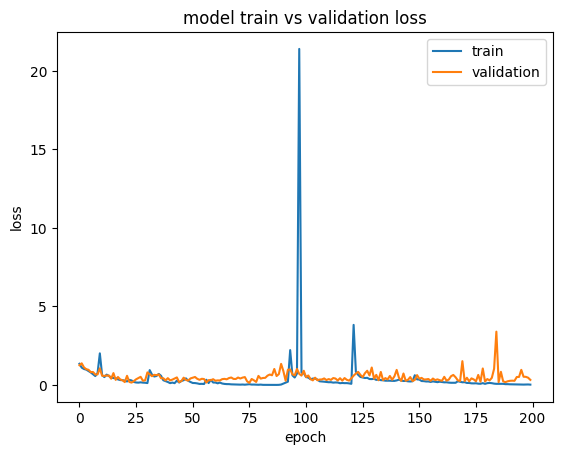

In [57]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

# 10. Evaluation using Confusion Matrix and Accuracy

In [100]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [106]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 40ms/step


In [107]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [108]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[8, 1],
        [0, 3]],

       [[9, 0],
        [1, 2]],

       [[9, 0],
        [0, 3]],

       [[9, 0],
        [0, 3]]], dtype=int64)

In [109]:
accuracy_score(ytrue, yhat)

0.9166666666666666

# 11. Test in Real Time

In [14]:
colors = [(245,117,16), (117,245,16), (16,117,245), (20,20,245)]
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

con HOLISTIC

In [ ]:
# 1. New detection variables
sequence = []
predictions = []
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
               
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
                       
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:                     
                    gesto = actions[np.argmax(res)]
             
            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(gesto), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()

con HANDS

In [18]:
# 1. New detection variables
sequence = []
predictions = []
gesto = ""
threshold = 0.5

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_hands.Hands(max_num_hands=2, min_detection_confidence=0.5) as hands:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        if not ret:
            print("Ignoring empty camera frame.")
            # If loading a video, use 'break' instead of 'continue'.
            continue
        
        # Make detections
        image, results = mediapipe_detection(frame, hands)
        print(results)        
        print("which hand?", results.multi_handedness)

        first_hand_keypoints = np.zeros(21*3)
        second_hand_keypoints = np.zeros(21*3)
    
        if results.multi_hand_landmarks:
            for num, hand_landmarks in enumerate(results.multi_hand_landmarks):        

                mp_drawing.draw_landmarks(     
                    image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2),
                    mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                    )
                
                if num == 0:   
                    first_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n1st hand kp:", first_hand_keypoints_test)
                if num == 1:
                    second_hand_keypoints = extract_keypoints_hands(results, hand_landmarks)
                    #print("\n2nd hand kp:", second_hand_keypoints_test)

            keypoints = np.concatenate([first_hand_keypoints, second_hand_keypoints])    

        else: 
            keypoints = np.zeros(21*6)
            print("no detect")
                        
        # 2. Prediction logic
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
                       
        #3. Viz logic
            if np.unique(predictions[-10:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold:                     
                    gesto = actions[np.argmax(res)]
             
            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(gesto), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        img_name = os.path.join(r"C:\Users\follo\OneDrive\Desktop", "test.png")
        print(img_name)
        cv2.imwrite(img_name, image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
C:\Users\follo\OneDrive\Desktop\test.png
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
C:\Users\follo\OneDrive\Desktop\test.png
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
C:\Users\follo\OneDrive\Desktop\test.png
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
C:\Users\follo\OneDrive\Desktop\test.png
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
C:\Users\follo\OneDrive\Desktop\test.png
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
C:\Users\follo\OneDrive\Desktop\test.png
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
C:\Users\follo\OneDrive\Desktop\test.png
<class 'mediapipe.python.solution_base.SolutionOutputs'>
which hand? None
no detect
C:\Users\follo\OneDrive\Desktop\test.png
